In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from flask import Flask, jsonify, request

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
inspector.get_table_names()



['measurement', 'station']

In [11]:
# Retrieve all column names and types from table 'Station'
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Retrieve all column names and types from the table 'Measurement'
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])





id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
#session = Session(engine)

In [15]:

most_recent_date_entered = engine.execute('SELECT max(date) FROM Measurement').fetchone()
print(most_recent_date_entered[0])


2017-08-23


# Exploratory Climate Analysis

2016-08-23


C:\Users\lisag\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


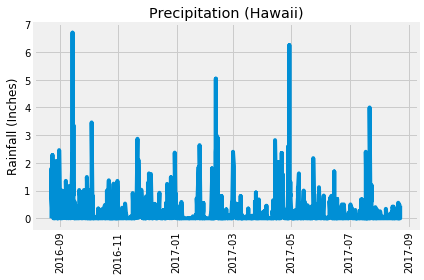

<Figure size 432x288 with 0 Axes>

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores

session = Session(engine)                                      

date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
order_by(Measurement.date).statement


# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.read_sql(date_prcp_query, engine).dropna()
date_prcp_df.head(5)
date_prcp_df.count()


# Sort the dataframe by date

date_prcp_df = date_prcp_df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data

date_prcp_df['date']  = pd.to_datetime(date_prcp_df['date'])
plt.plot(date_prcp_df['date'], date_prcp_df['prcp'])
plt.title("Precipitation (Hawaii)")
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

plt.savefig("Images/precipitation_over_most_recent_year")



In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = engine.execute('select count(id) from station').fetchone()
print('The total number of stations available in this data set is: ', number_of_stations[0]) 

The total number of stations available in this data set is:  9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations_desc_order = engine.execute('select station, count(station) from measurement group by station order by count(station) desc').fetchall()
most_active_stations_desc_order



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


temp_observations = engine.execute('select min(tobs), max(tobs), avg(tobs) from Measurement where station == "USC00519281"').fetchall() 
print(temp_observations)




[(54.0, 85.0, 71.66378066378067)]


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

result_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>one_year_ago).\
                filter(Measurement.station == "USC00519281")
result_temp_df = pd.DataFrame(result_temp[:],columns=['Date','Temp Observations'])
result_temp_df.head()

,Date,Temp Observations
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


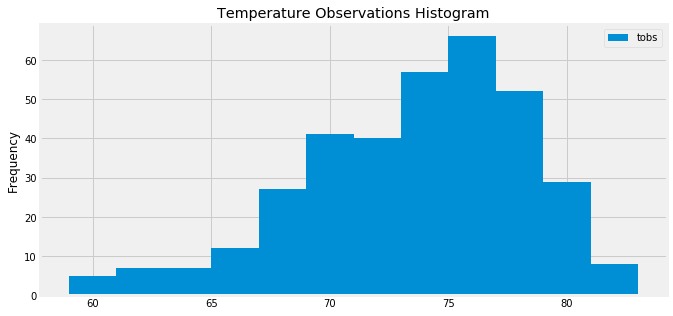

In [22]:
plt.figure(figsize=(10,5))
plt.hist(result_temp_df["Temp Observations"], bins=12, label='tobs')
plt.ylabel("Frequency")
plt.title("Temperature Observations Histogram")
plt.legend()
plt.savefig("Images/Temperature_Observations_Histogram.png")
plt.show()

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2016-08-13','2016-08-23')
print(trip_temp)


[(72.0, 78.08571428571429, 83.0)]


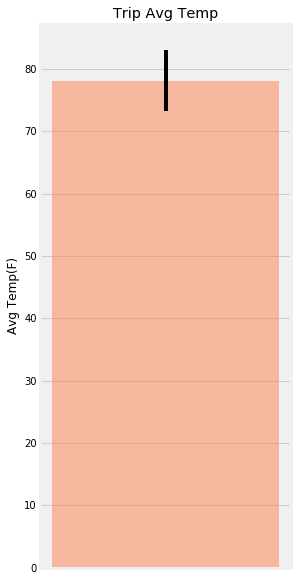

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(4,10))
plt.bar(1, trip_temp[0][1], color='coral', alpha=0.5, yerr=trip_temp[0][2]-trip_temp[0][1])
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylabel("Avg Temp(F)")
plt.savefig("Images/Trig_Avg_Temp_ErrBar.png")



In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_per_station = func.avg(Measurement.prcp).label("Rainfall_per_station")
last_years_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation, \
                            func.avg(Measurement.prcp).label("Rainfall")).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= '2016-08-13').\
                filter(Measurement.date <= '2016-08-23').group_by(Measurement.station).order_by(rainfall_per_station.desc())


index = 0
for rf in last_years_rainfall:
    print(last_years_rainfall[index])
    index = index + 1


('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.8172727272727272)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.4972727272727273)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.18363636363636363)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.07636363636363637)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.05090909090909091)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.021428571428571432)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)


In [97]:
#STEP 2 CREATE A CLIMATE APP TO DESIGN A FLASK API USING THE QUERIES ABOVE.

In [32]:
#Flask setup
app = Flask(__name__)

In [33]:
# Use FLASK to create your routes.

### Routes

# `/`

# Home page.
# List all routes that are available.

@app.route("/")

def welcome():
   
    return (
        "<h1> Hawaii Precipitation and Temperature Observations Data</h1>"
        
        "<h3>Choose a route from below:</h3>"
        
        "Precipiation from 2016-08-23 to 2017-08-23.<br/>"
        "<a target='_blank' href='http://localhost:9000/api/v1.0/precipitation'>Precipitation Data</a><br/><br/>"
        
        " Hawaii Weather stations.<br/>"
        "<a target='_blank'href= 'http://localhost:9000/api/v1.0/stations'>Weather Stations Data</a><br/><br/>"
        
        "Temperature Observations (tobs) from 2016-08-23 to 2017-08-23.<br/>"
        "<a target='_blank' href='http://localhost:9000/api/v1.0/tobs'>Temperature Observations Data</a><br/><br/>"
        
        "Type in a date (using this format: 2017-02-24) to see the min, max and avg temperature since that date.<br/>"
        "<form action='http://localhost:9000/api/v1.0/temp/' method='get'><input name='start' id='start' value='' placeholder='yyyy-mm-dd' ><div><button>Enter</button></div></form>"
        
        "Type in a start and end date (using this format: 2016-08-23 and 2017-08-23) to see the min, max and avg temperature for that range.<br/>"
        "<form action='http://localhost:9000/api/v1.0/temp-range/' method='get'> Start Date <input name='start' id='start' value='' placeholder='yyyy-mm-dd'>End Date <input name='end' id='end' value='' placeholder='yyyy-mm-dd'><div><button>Enter</button></div></form>"
        
        
    )



In [34]:
# `/api/v1.0/precipitation`

# Convert the query results to a Dictionary using `date` as the key and `prcp` as the value.

# Return the JSON representation of your dictionary.

begin_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

@app.route("/api/v1.0/precipitation")

def precipitation():

    # Retrieve the last 12 months of precipitation data
    results = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > begin_date).\
                        order_by(Measurement.date).all()

    # Create a dictionary from the row data and append to a list of for the precipitation data
    precipitation_data = []
    for prcp_data in results:
        prcp_data_dict = {}
        prcp_data_dict["Date"] = prcp_data.date
        prcp_data_dict["Precipitation"] = prcp_data.prcp
        precipitation_data.append(prcp_data_dict)
        

    return jsonify(precipitation_data)

In [35]:
# `/api/v1.0/stations`
# Return a JSON list of stations from the dataset.

@app.route("/api/v1.0/stations")

def stations():
    
    # Query all the stations
    results = session.query(Station).all()

    # Create a dictionary from the row data and append to a list of all_stations.
    all_stations = []
    for stations in results:
        stations_dict = {}
        stations_dict["Station"] = stations.station
        stations_dict["Station Name"] = stations.name
        stations_dict["Latitude"] = stations.latitude
        stations_dict["Longitude"] = stations.longitude
        stations_dict["Elevation"] = stations.elevation
        all_stations.append(stations_dict)
    
    return jsonify(all_stations)

In [36]:
# `/api/v1.0/tobs`
# query for the dates and temperature observations from a year from the last data point.
# Return a JSON list of Temperature Observations (tobs) for the previous year.

@app.route("/api/v1.0/tobs")

def tobs():
    
    # Query all the stations and for the given date. 
    results = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                    group_by(Measurement.date).\
                    filter(Measurement.date > begin_date).\
                    order_by(Measurement.station).all()
                    
    # Create a dictionary from the row data and append to a list of for the temperature data.
    temp_observations = []
    for tobs_data in results:
        tobs_data_dict = {}
        tobs_data_dict["Station"] = tobs_data.station
        tobs_data_dict["Date"] = tobs_data.date
        tobs_data_dict["Temperature"] = tobs_data.tobs
        temp_observations.append(tobs_data_dict)
    
    return jsonify(temp_observations)

In [37]:
# `/api/v1.0/<start>`
#  Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start date
#  When given the start date, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

@app.route("/api/v1.0/temp/", methods=['get'])

def start_stats(start=None):
    
    start = request.args.get('start')
    
    # Query all the stations and for the given date. 
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start).all()

    # Create a dictionary from the row data and append to a list of for the temperature data.
    start_dte_only = []
    
    for Tmin, Tmax, Tavg in results:
        start_dte_only_dict = {}
        start_dte_only_dict["Minimum Temp"] = Tmin
        start_dte_only_dict["Maximum Temp"] = Tmax
        start_dte_only_dict["Average Temp"] = Tavg
        start_dte_only.append(start_dte_only_dict)
    
    return jsonify(start_dte_only)

In [39]:
# `/api/v1.0/<start>/<end>`
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start-end range.
# When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

@app.route("/api/v1.0/temp-range/", methods=['get'])
def calc_stats(start=None, end=None):
    
    start = request.args.get('start')
    end   = request.args.get('end') 
    
    # Query all the stations and for the given range of dates. 
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start).filter(Measurement.date <= end).all()

    # Create a dictionary from the row data and append to a list of for the temperature data.
    start_end_dates = []
    
    for Tmin, Tmax, Tavg in results:
        start_end_dates_dict = {}
        start_end_dates_dict["Minimum Temp"] = Tmin
        start_end_dates_dict["Maximum Temp"] = Tmax
        start_end_dates_dict["Average Temp"] = Tavg
        start_end_dates_dict['start']=start
        start_end_dates_dict['end']=end
        start_end_dates.append(start_end_dates_dict)
    
    return jsonify(start_end_dates)




In [ ]:
#if __name__ == '__main__':
#    app.run(debug=True)



if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 8888, app)
    

## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Store the start and end date of the trip into variables

start_date = '2017-08-13'
end_date ='2017-08-23'

# Use the start and end date to create a range of dates

dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()
print(dates)




[('2017-08-13',), ('2017-08-14',), ('2017-08-15',), ('2017-08-16',), ('2017-08-17',), ('2017-08-18',), ('2017-08-19',), ('2017-08-20',), ('2017-08-21',), ('2017-08-22',), ('2017-08-23',)]


In [37]:
# put those dates from the query into a tuple

dates_of_trip = [x[0] for x in dates]
print(dates_of_trip)

['2017-08-13', '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23']


In [38]:
# Strip off the year and save a list of %m-%d strings

dates_strip_year = [x[5:] for x in dates_of_trip]
print(dates_strip_year)

['08-13', '08-14', '08-15', '08-16', '08-17', '08-18', '08-19', '08-20', '08-21', '08-22', '08-23']


In [39]:
# store the first month/day and the last month/day in variables

first_month_day = dates_strip_year[0]
print(first_month_day)
last_month_day = dates_strip_year[-1]
print(last_month_day)

08-13
08-23


In [41]:
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= first_month_day).filter(func.strftime("%m-%d", Measurement.date) <= last_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 08-13 to 08-23")
daily_normals

Aggregate Daily Normals for 08-13 to 08-23


[(71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0)]

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [48]:
#Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])
daily_normals_df

,tmin,tavg,tmax
0,71.0,76.982456,84.0
1,71.0,76.777778,82.0
2,69.0,76.471698,83.0
3,69.0,76.080000,83.0
4,69.0,76.125000,83.0
5,70.0,76.923077,84.0
6,69.0,75.946429,85.0
7,68.0,76.452830,82.0
8,67.0,76.400000,83.0
9,69.0,76.471698,84.0


In [55]:
# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates
daily_normals_df

,tmin,tavg,tmax,date
date,,,,
2017-08-13,71.0,76.982456,84.0,2017-08-13
2017-08-14,71.0,76.777778,82.0,2017-08-14
2017-08-15,69.0,76.471698,83.0,2017-08-15
2017-08-16,69.0,76.080000,83.0,2017-08-16
2017-08-17,69.0,76.125000,83.0,2017-08-17
2017-08-18,70.0,76.923077,84.0,2017-08-18
2017-08-19,69.0,75.946429,85.0,2017-08-19
2017-08-20,68.0,76.452830,82.0,2017-08-20
2017-08-21,67.0,76.400000,83.0,2017-08-21


In [56]:
# Switch the date to datetime on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')
#daily_normals_df

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df


,tmin,tavg,tmax
date,,,
2017-08-13,71.0,76.982456,84.0
2017-08-14,71.0,76.777778,82.0
2017-08-15,69.0,76.471698,83.0
2017-08-16,69.0,76.080000,83.0
2017-08-17,69.0,76.125000,83.0
2017-08-18,70.0,76.923077,84.0
2017-08-19,69.0,75.946429,85.0
2017-08-20,68.0,76.452830,82.0
2017-08-21,67.0,76.400000,83.0


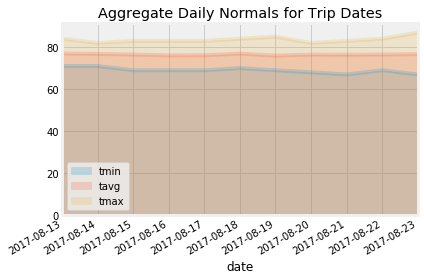

In [59]:
# Plot the daily normals as an area plot with `stacked=False`
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.show()